In [1]:
# --- Step 1: Import Libraries and Load Data ---

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files

# Import necessary libraries from scikit-learn and TensorFlow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, Bidirectional # Ensure GRU and Bidirectional are imported
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# --- Data Loading ---
print("Please upload your 'control_surface_vibrations_100k.csv' file.")
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

print("\nOriginal dataset shape:", df.shape)

Please upload your 'control_surface_vibrations_100k.csv' file.


Saving control_surface_vibrations_80k.csv to control_surface_vibrations_80k.csv

Original dataset shape: (80000, 10)


In [3]:
# --- Step 2: Subset Data, Define Targets, and Split ---

# One-hot encode categorical features
if 'Surface_Type' in df.columns and 'Material' in df.columns:
    df = pd.get_dummies(df, columns=['Surface_Type', 'Material'], drop_first=True)

# Create a random subset of 80,000 samples
if len(df) > 80000:
    df_subset = df.sample(n=80000, random_state=42)
    print(f"\nCreated a random subset of {len(df_subset)} samples.")
else:
    df_subset = df

# Define target columns
target_cols = ['Natural_Frequency', 'Damping_Ratio']

# Create features (X) and targets (y) from the subset
X = df_subset.drop(columns=target_cols)
y = df_subset[target_cols]

# Perform an 80/20 train-test split on the 80,000 samples
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training samples: {len(X_train)} (80%)")
print(f"Testing samples: {len(X_test)} (20%)")

Training samples: 64000 (80%)
Testing samples: 16000 (20%)


In [4]:
# --- Step 3: Scale Features and Targets ---
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.transform(X_test)

y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# --- Step 4: Reshape Features for GRU Input ---
X_train_stacked = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_stacked = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [5]:
# --- Step 5: Define the Bidirectional GRU Model ---

model = Sequential()

# First Bidirectional GRU layer.
model.add(Bidirectional(GRU(128, activation='tanh', return_sequences=True),
                        input_shape=(X_train_stacked.shape[1], X_train_stacked.shape[2])))
model.add(Dropout(0.2))

# Second Bidirectional GRU layer.
model.add(Bidirectional(GRU(64, activation='tanh')))
model.add(Dropout(0.2))

# Dense layers for processing
model.add(Dense(32, activation='relu'))

# Output layer for regression
model.add(Dense(2, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

print("\nBidirectional GRU Regression Model Summary:")
model.summary()


Bidirectional GRU Regression Model Summary:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 1, 256)         │       109,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       123,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,898 (925.38 KB)

 Trainable params: 236,898 (925.38 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# --- Step 6: Train the Model with Early Stopping ---

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

print("\n--- Starting Model Training ---")
history = model.fit(
    X_train_stacked,
    y_train_scaled,
    epochs=50,
    batch_size=128,
    validation_data=(X_test_stacked, y_test_scaled),
    callbacks=[early_stopping],
    verbose=1
)
print("--- Model Training Finished ---")


--- Starting Model Training ---
Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.0211 - mae: 0.0973 - val_loss: 0.0051 - val_mae: 0.0548
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0058 - mae: 0.0593 - val_loss: 0.0050 - val_mae: 0.0543
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0056 - mae: 0.0576 - val_loss: 0.0050 - val_mae: 0.0540
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0054 - mae: 0.0565 - val_loss: 0.0049 - val_mae: 0.0539
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.0052 - mae: 0.0558 - val_loss: 0.0049 - val_mae: 0.0540
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0052 - mae: 0.0553 - val_loss: 0.0051 - val_mae: 0.0546
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0052 - mae: 0.0555 - val_loss: 0.0049 - val_mae: 0.0539
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0051 - mae: 0.0548 - val_loss: 0.0050 - val_mae: 0.0544
Epoch 9/50
50

500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

--- R-squared (Performance Score) ---
Natural_Frequency R-squared: 0.5265 (Explains 52.65% of the variance)
Damping Ratio R-squared: 0.9149 (Explains 91.49% of the variance)

--- Sample of Actual vs. Predicted Values ---
   Actual Natural_Frequency  Predicted Natural_Frequency  Actual Damping_Ratio  Predicted Damping_Ratio
0                    17.442                    18.075369                 2.272                 2.313282
1                    15.487                    15.591964                 0.327                 0.513680
2                    14.704                    14.655467                 2.336                 2.419031
3                    16.412                    18.704000                 2.792                 2.710078
4                    15.847                    17.456781                 2.183                 2.377515
5                    17.469                    18.943493                 3.532                 3.213890
6        

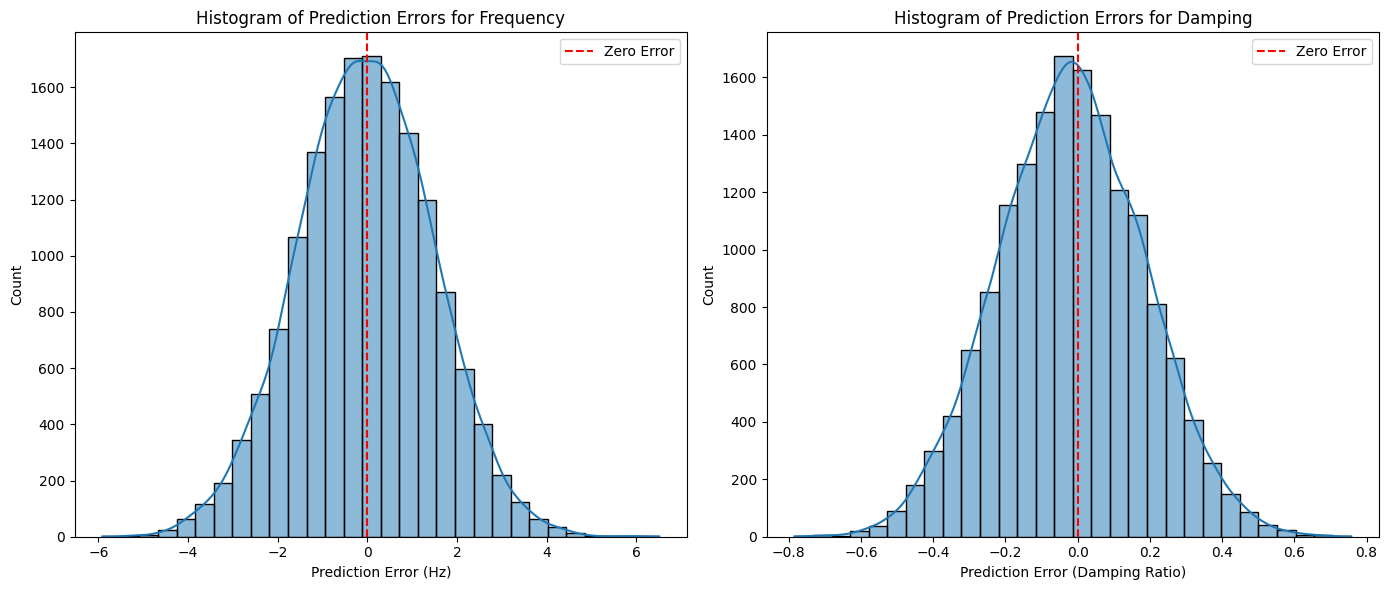

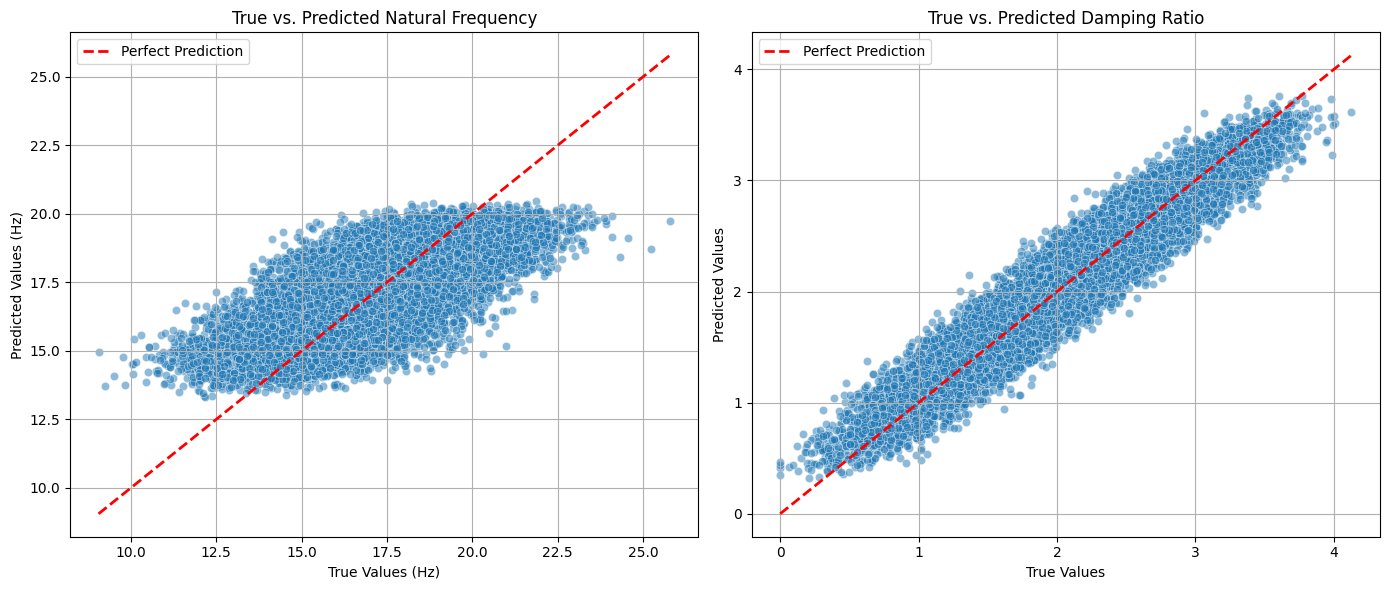

In [9]:
# --- Step 7: Evaluate Performance and Plot Results ---

# Predict and inverse transform
y_pred_scaled = model.predict(X_test_stacked)
y_pred = y_scaler.inverse_transform(y_pred_scaled)

# --- R-squared (Performance Score) ---
print("\n--- R-squared (Performance Score) ---")
r2_freq = r2_score(y_test['Natural_Frequency'], y_pred[:, 0])
r2_damp = r2_score(y_test['Damping_Ratio'], y_pred[:, 1])
print(f"Natural_Frequency R-squared: {r2_freq:.4f} (Explains {r2_freq*100:.2f}% of the variance)")
print(f"Damping Ratio R-squared: {r2_damp:.4f} (Explains {r2_damp*100:.2f}% of the variance)")

# --- Sample of Actual vs. Predicted Values ---
print("\n--- Sample of Actual vs. Predicted Values ---")
results_df = pd.DataFrame({
    'Actual Natural_Frequency': y_test['Natural_Frequency'].values,
    'Predicted Natural_Frequency': y_pred[:, 0],
    'Actual Damping_Ratio': y_test['Damping_Ratio'].values,
    'Predicted Damping_Ratio': y_pred[:, 1]
})
print(results_df.head(10).to_string())

# Calculate prediction errors (residuals)
results_df['Freq_Error'] = results_df['Actual Natural_Frequency'] - results_df['Predicted Natural_Frequency']
results_df['Damping_Error'] = results_df['Actual Damping_Ratio'] - results_df['Predicted Damping_Ratio']

# --- Histogram of Prediction Errors ---
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(results_df['Freq_Error'], kde=True, bins=30)
plt.axvline(x=0, color='r', linestyle='--', label='Zero Error')
plt.title('Histogram of Prediction Errors for Frequency')
plt.xlabel('Prediction Error (Hz)')
plt.ylabel('Count')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(results_df['Damping_Error'], kde=True, bins=30)
plt.axvline(x=0, color='r', linestyle='--', label='Zero Error')
plt.title('Histogram of Prediction Errors for Damping')
plt.xlabel('Prediction Error (Damping Ratio)')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()

# --- True vs. Predicted Scatter Plots ---
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=results_df, x='Actual Natural_Frequency', y='Predicted Natural_Frequency', alpha=0.5)
plt.plot([y_test['Natural_Frequency'].min(), y_test['Natural_Frequency'].max()],
         [y_test['Natural_Frequency'].min(), y_test['Natural_Frequency'].max()],
         'r--', lw=2, label='Perfect Prediction')
plt.title('True vs. Predicted Natural Frequency')
plt.xlabel('True Values (Hz)')
plt.ylabel('Predicted Values (Hz)')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
sns.scatterplot(data=results_df, x='Actual Damping_Ratio', y='Predicted Damping_Ratio', alpha=0.5)
plt.plot([y_test['Damping_Ratio'].min(), y_test['Damping_Ratio'].max()],
         [y_test['Damping_Ratio'].min(), y_test['Damping_Ratio'].max()],
         'r--', lw=2, label='Perfect Prediction')
plt.title('True vs. Predicted Damping Ratio')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()